# CNN Training Notebook

Here we will construct a model starting with the resnet model and use transfer learning to train it to predict the weights of cows.

### Table of Contents

* [Data](#data)
    * [Load Data](#load)
    * [Preprocess](#prep)
    * [Split Data](#split)
    * [Create Data Generator](#gen)
    
* [Training Models](#models)
    * [CNN Model](#cnn)
    * [Vision Transformer Model](#vit)
    
* [Evaluation](#eval)
    * [CNN Evaluation](#cnneval)
    * [Transformer Evaluation](#viteval)
    

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import os
from PIL import Image
from tqdm.notebook import tqdm
import keract
from matplotlib import pyplot as plt

In [2]:
# fix some memory expansion issues by allowing growth on the gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data <a class="anchor" id="data"></a>

In [3]:
DATABASE_LOCATION = 'C:/Users/derek/Documents/cattle_data'
INPUT_PATH = DATABASE_LOCATION+'/training'
DATASET = 'training.json'

### Load Data <a class="anchor" id="load"></a>

In [4]:
# load training data
import json
import pandas as pd
with open(os.path.join(INPUT_PATH, DATASET), 'r') as file:
        frame = json.load(file)
df = pd.DataFrame(frame)
df.timestamp = pd.to_datetime(df['timestamp'], unit='ms')
print(len(df))
df.head()

92857


,weight,prediction,auction,timestamp,path
0,565.0,"[{'Label': 'cow', 'Prob': '0.10884704', 'Box':...",rimbey,2021-11-30 09:07:05.958,C:/Users/derek/Documents/cattle_data/training/...
1,565.0,"[{'Label': 'cow', 'Prob': '0.14765938', 'Box':...",rimbey,2021-11-30 09:07:06.978,C:/Users/derek/Documents/cattle_data/training/...
2,565.0,"[{'Label': 'cow', 'Prob': '0.81416804', 'Box':...",rimbey,2021-11-30 09:07:07.990,C:/Users/derek/Documents/cattle_data/training/...
3,565.0,"[{'Label': 'cow', 'Prob': '0.85627973', 'Box':...",rimbey,2021-11-30 09:07:08.981,C:/Users/derek/Documents/cattle_data/training/...
4,565.0,[],rimbey,2021-11-30 09:07:09.986,C:/Users/derek/Documents/cattle_data/training/...


In [5]:
# drop data with no image
def has_image(path):
    return os.path.exists(path)

dne = df[~df.path.apply(has_image)]
df = df[df.path.apply(has_image)]

In [6]:
len(df)

84427

<AxesSubplot:>

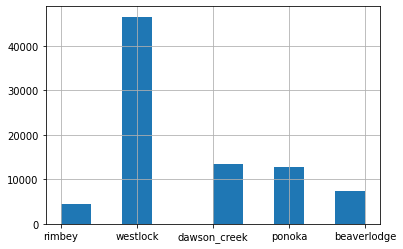

In [7]:
# look at auction distribution of data
df.auction.hist()

Most of our data is coming from westlock. They simply have more cows go through in a day than any other auction. 

### Preprocess <a class="anchor" id="prep"></a>

The preprocessing section only needs to be run once for ever new batch of cleaned training data. If the training data in the folder is of sufficient quantity and has the black borders around the images, skip this section and create the data generator. 

In [217]:
# Add padding to image 
# Function taken from:
# https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

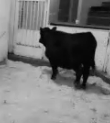

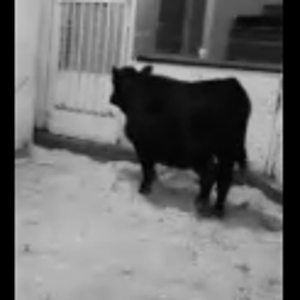

In [113]:
# try on one image
path = os.path.join(INPUT_PATH, 'singles/rimbey_im_{}.png'.format(126895))
img = Image.open(path)
display(img)
im_new = expand2square(img, (0)).resize((300, 300))
display(im_new)


In [218]:
# get paths to all images
paths = []

# add paths
for p in os.listdir(os.path.join(INPUT_PATH, 'singles')):
    paths.append(os.path.join(INPUT_PATH, 'singles', p))
    
print(len(paths))
print(paths[0])

84427
C:/Users/derek/Documents/cattle_data/training\singles\beaverlodge_im_245307.png


In [219]:
# preprocess entire dataset
pbar = tqdm(total=len(paths))

for path in paths:
    
    img = Image.open(path)
    img = expand2square(img, (0)).resize((224,224))
    img.save(path)
    pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████| 84427/84427 [10:40<00:00, 142.78it/s]

<AxesSubplot:>

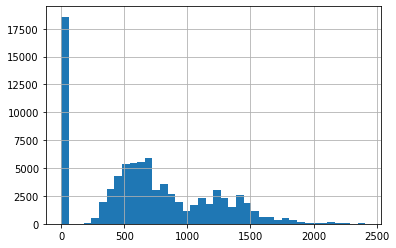

In [8]:
# look at the data distribution
df.weight.hist(bins=40)

Some of the data for single cows has zero weight if the cleaning algorithm was not confident that it could assign a weight to the image, we need to make sure we remove this data so it does not skew our training results. 

In [9]:
# trim the data to a constrained weight range 
df_trim = df[(df.weight > 400) & (df.weight < 1450)]

In [10]:
len(df_trim)

55010

<AxesSubplot:>

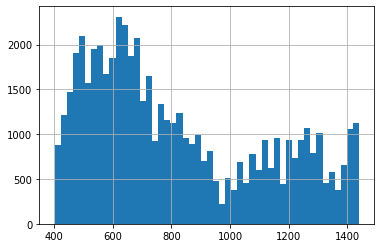

In [11]:
df_trim.weight.hist(bins=50)

We now have much less data since we trimming the data with zero weight and we are also trimming the tails off of the good data. The new data distribution is much more uniform.

### Split Data <a class="anchor" id="split"></a>

Splitting the data is an extreemly important step in the training process. It is necissary that we use part of the dataset for testing that has not been seen by the network during training. 
In addition to this split, we are going to perform another split to reserve a portion of the data for evaluation of our models once the training has completed. We want to evaluate how the model performs on new cows that go through the auction. Since the training and testing data is selected at random from the datset, and the data has multiple images of each cow, it is possible that some pictures of the same cow are in the training set as well as the testing set. To achieve a more reliable evaluation of our models, we will use data that has been reciently added to the dataset. This way the entire evaluation set will be new cows. 

In [12]:
# reserve recent data for evaluation
# last reserve from 2022-01-22
cuttoff = '2022-02-13'
eval_df = df_trim[df_trim.timestamp > cuttoff].copy()
training_df = df_trim[df_trim.timestamp < cuttoff].copy()

In [13]:
# split the training data into training and testing
def train_test_split(d, frac=0.2):
    test = d.sample(frac=frac, axis=0)
    train = d.drop(index=test.index).sample(frac=1, axis=0)
    return train, test

In [14]:
train_df, test_df = train_test_split(training_df)

In [15]:
# perform extra cleaning on evaluation set

def clean(d):
    
    pred = d.prediction
    
    if len(pred) >= 1:
        
        #print(type(pred))
        #print(pred)
        if type(pred) == pd.core.frame.DataFrame:
            pred = pred.iloc[0]
            prob = pred['Prob']
        elif type(pred) == list:
            if len(pred) == 1:
                pred = pred[0]
                prob = pred['Prob']
            else:
                prob = pred[1]
        else:
            prob = pred['Prob']
        
        #print(pred)
        #print(prob)
        
        if d.auction == 'ribey':
            thresh = 0.15
            
        elif d.auction == 'westlock':
            thresh = 0.2
            
        elif d.auction == 'dawson_creek':
            thresh = 0.08
        
        elif d.auction == 'ponoka':
            thresh = 0.1
            
        elif d.auction == 'beaverlodge':
            thresh = 0.15
            
        else:
            thresh = 0.1
            
        if float(prob) > thresh:
            return True
        else:
            return False
    else:
        return False

print('Length before cleaning: {}'.format(len(eval_df)))
ev_df = eval_df[eval_df.apply(clean, axis=1)]
print('Length after cleaning: {}'.format(len(ev_df)))

Length before cleaning: 4754
Length after cleaning: 4589


### Create Data Generator <a class="anchor" id="gen"></a>

Tensorflow has a nice feature called an image data generator. We can use this to load data from our dataframe along with images from the image folder in batches as the network trains. This allows us to train a network with a large dataset without filling up the memory. 
We will use the `flow_from_dataframe` function in particular. This will reference two columns in our training and testing dataframes:
* The `weight` column provides the target data `y` for training
* The `path` column provides a path to the input training image which is our `X` variable

I have set up the generator with a `color` option so we can load the images with either 1 channels or 3 channels depending on how our model is built

In [29]:
def create_gen(model_input_shape, color='grayscale'):
    
    train_datagen = image.ImageDataGenerator(
            rescale=1./255,
            #shear_range=0.2,
            zoom_range=0.1,
            horizontal_flip=True
            )

    test_datagen = image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=os.path.join(INPUT_PATH, 'img'),
            x_col='path',
            y_col='weight',
            target_size=model_input_shape,
            batch_size=128,
            class_mode='raw',
            color_mode=color,
            )

    validation_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=os.path.join(INPUT_PATH, 'img'),
            x_col='path',
            y_col='weight',
            target_size=model_input_shape,
            batch_size=128,
            class_mode='raw',
            color_mode=color,
            )

    return train_generator, validation_generator

In [30]:
train_generator, val_generator = create_gen((224,224), color='rgb')

Found 40205 validated image filenames.
Found 10051 validated image filenames.


## Training Models <a class="anchor" id="models"></a>

### CNN Models <a class="anchor" id="cnn"></a>

Two CNN (convolutional neural network) models are built. 
* A custom built generic R-CNN
* A pre-trained exception model using transfer learning

  

### Custom CNN Model

In [22]:
def build_model(filters) :
    
    input_shape = 224
    smallest_feature_map = 24
    
    input_layer = tf.keras.Input(shape=(224, 224, 1))
    x = input_layer
    
    feat_size = input_shape
    
    for filt in filters:
        
        x2 = tf.keras.layers.Conv2D(filters=filt, kernel_size=7, padding='same')(x)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.Activation('relu')(x2)
        
        x = tf.keras.layers.Conv2D(filters=filt, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Add()([x, x2])
        
        if feat_size > smallest_feature_map:
            x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)
            feat_size = feat_size//2

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(filters[-1])(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    
    bias_init = tf.keras.initializers.Constant(df.weight.mean())

    outputs = tf.keras.layers.Dense(1, bias_initializer=bias_init)(x) # reduce to one node for weight prediction
    model = tf.keras.Model(input_layer, outputs)

    return model

In [23]:
model = build_model([32, 64, 128, 128, 256, 512, 256, 128])
model.compile(
        loss= "mean_squared_error" , 
        optimizer="adam", 
        metrics=["mean_squared_error"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 224, 224, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 224, 224, 32  1600        ['input_2[0][0]']                
                                )                                                           

In [130]:

hist= model_ex1.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=100,
        validation_data=val_generator,
        validation_steps=25,
        #callbacks=[tensorboard_callback]
        )

Epoch 1/100
300/300 [==============================] - 197s 636ms/step - loss: 14734.2695 - mean_squared_error: 14734.2695 - val_loss: 13613.8008 - val_mean_squared_error: 13613.8008
Epoch 2/100
300/300 [==============================] - 183s 609ms/step - loss: 11984.7070 - mean_squared_error: 11984.7070 - val_loss: 10741.0234 - val_mean_squared_error: 10741.0234
Epoch 3/100
300/300 [==============================] - 182s 606ms/step - loss: 11077.1680 - mean_squared_error: 11077.1680 - val_loss: 11151.3242 - val_mean_squared_error: 11151.3242
Epoch 4/100
300/300 [==============================] - 183s 610ms/step - loss: 9966.2441 - mean_squared_error: 9966.2441 - val_loss: 10705.4229 - val_mean_squared_error: 10705.4229
Epoch 5/100
300/300 [==============================] - 183s 610ms/step - loss: 9550.4238 - mean_squared_error: 9550.4238 - val_loss: 10532.5801 - val_mean_squared_error: 10532.5801
Epoch 6/100
300/300 [==============================] - 184s 611ms/step - loss: 9206.4229 

The model was trained for 200 epochs with a final training loss of 1781 and a validation loss of 13330. The network was trained for another 100 epochs for a final training loss of 1161 and validation loss of 12539. This resulted in a training accuracy of **96.8%** and a validation accuracy of **90.3%**

Note: The accuracy score is not a metric included in the fit process. The accuracy is calculated using the `test_on_image` function found in the [Evaluation](#eval) section. 

Accuracy is calculated using the following formula: $$ a = (1 -  \frac{ε} {N}) * 100 \% $$

Where $ ε $ is the residuals of the predictions made: $$ \epsilon =  \sum \limits _{i=0} ^{N} \frac {|y - \hat{y}|} {y} $$ 

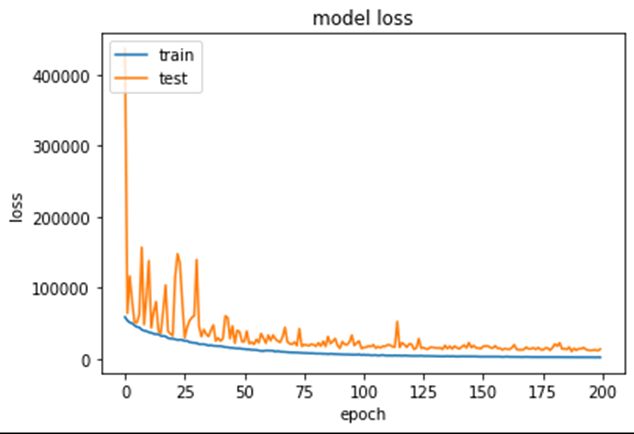 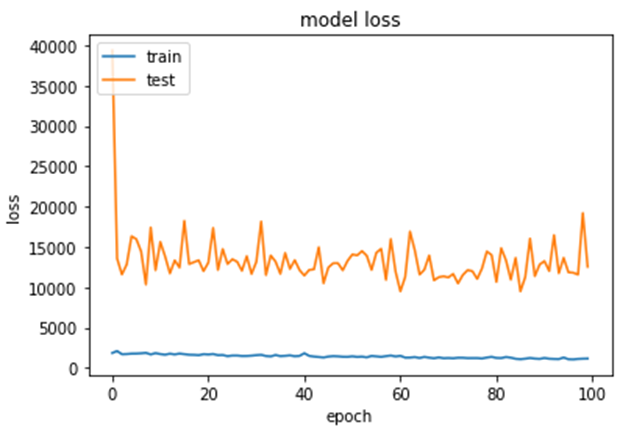

In [ ]:
model.save(DATABASE_LOCATION+"/models/custom_best_model")

### Xception CNN Model

In [20]:
x_model = keras.applications.xception.Xception(weights='imagenet',
                input_shape=(224, 224, 3),
                include_top=False)

In [21]:
# freez the first n layers
for layer in x_model.layers[:10]:
    layer.trainable = False

In [22]:
# build new layers
input_layer = tf.keras.Input(shape=(224, 224, 3))


# use the whole model and add a couple layers
x = x_model(input_layer, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(100)(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

bias_init = keras.initializers.Constant(df.weight.mean())

outputs = keras.layers.Dense(1, bias_initializer=bias_init)(x) # reduce to one node for weight prediction
model = keras.Model(input_layer, outputs)

model.compile(
    loss= "mean_squared_error" , 
    optimizer="adam", 
    metrics=["mean_squared_error"])

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 100)               204900    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                           

In [31]:
hist = model_xcept.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=100,
        validation_data=val_generator,
        validation_steps=25,
        #callbacks=[tensorboard_callback]
        )

Epoch 1/100
300/300 [==============================] - 464s 2s/step - loss: 12952.6729 - mean_squared_error: 12952.6729 - val_loss: 12132.9297 - val_mean_squared_error: 12132.9297
Epoch 2/100
300/300 [==============================] - 309s 1s/step - loss: 10166.1309 - mean_squared_error: 10166.1309 - val_loss: 9950.7500 - val_mean_squared_error: 9950.7500
Epoch 3/100
300/300 [==============================] - 296s 986ms/step - loss: 8958.9814 - mean_squared_error: 8958.9814 - val_loss: 10229.7178 - val_mean_squared_error: 10229.7178
Epoch 4/100
300/300 [==============================] - 290s 964ms/step - loss: 7814.2832 - mean_squared_error: 7814.2832 - val_loss: 10686.6572 - val_mean_squared_error: 10686.6572
Epoch 5/100
300/300 [==============================] - 284s 945ms/step - loss: 7140.2329 - mean_squared_error: 7140.2329 - val_loss: 9040.8184 - val_mean_squared_error: 9040.8184
Epoch 6/100
300/300 [==============================] - 282s 938ms/step - loss: 6439.8442 - mean_squar

KeyboardInterrupt: 

In [ ]:
model_xcept.save(DATABASE_LOCATION+"/models/xcept_128_model")

The Xception model was trained over 3x100 epachs the images below show each of the consecutive training sessions. The final training loss is 3248, validation loss is 10939 training accuracy is **96.0%** and validation accuracy is **90.7%**. 

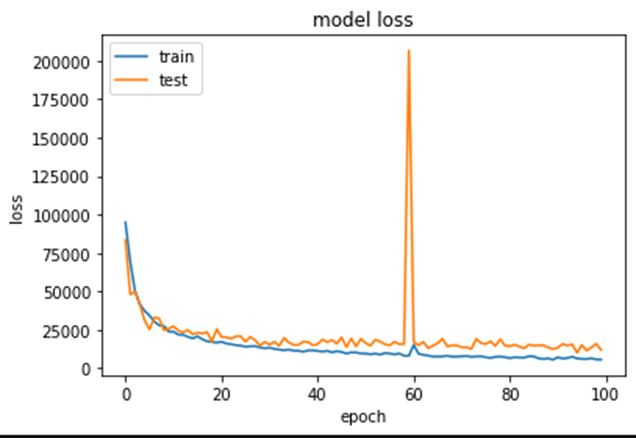 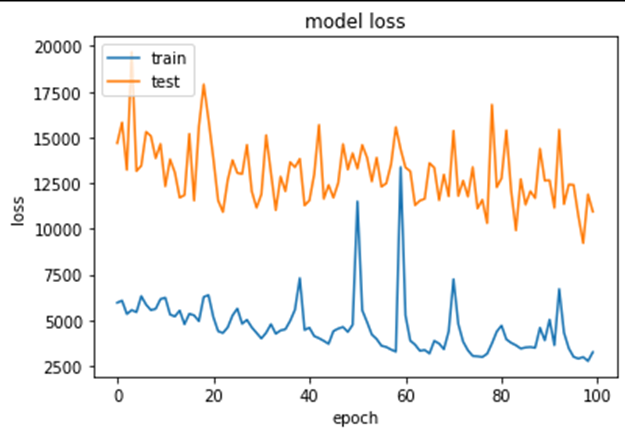 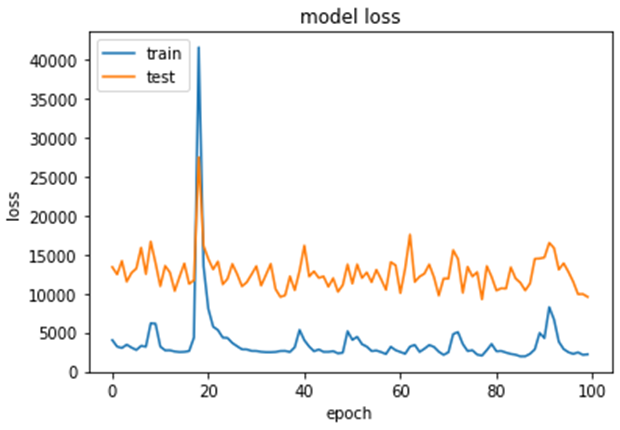

In [28]:
# unfreeze layers and continue training
for layer in model_xcept.layers[:10]:
    layer.trainable = True

It has been shown that using small batch sizes in training find minimums that have a Euclidian distance farther away from the initial network weights than larger batch sizes. I found that training the CNN first with a small batch size on less data and then retraining the network with a larger batch size on a larger data set achieved slightly better results than retraining the original network with more data and the same smaller batch size. 

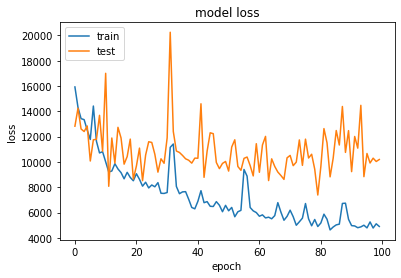

In [59]:
# Post-Trained on batch size 32
import matplotlib.pyplot as plt 
history = hist
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

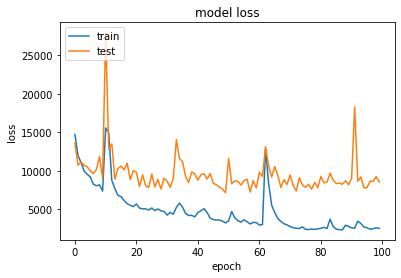

In [131]:
# Post-Trained on batch size 64
import matplotlib.pyplot as plt 
history = hist
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Vision Transformer Model (ViT) <a class="anchor" id="vit"></a>

Vision transformers have been known to perform well on images even better than CNNs when given enough data. We will train a generic ViT model from one of the Keras example pages __[here](https://keras.io/examples/vision/image_classification_with_vision_transformer/)__. And a compact convolutional ViT from __[here](https://keras.io/examples/vision/cct/)__. The code for both models is in the `vit.py` file. We will generate and train one at a time by calling the appropriate create function and then training the `model_vit`.

In [20]:
import importlib
import vit
importlib.reload(vit)

# create the generic ViT
#model_vit = vit.create_vit_model((224,224,1), 1)

# create the compact cnn ViT
model_vit = vit.create_cct_model()

In [21]:
BATCH_SIZE = 20
lr = 0.003 * BATCH_SIZE / 512

optimizer = vit.tfa.optimizers.AdamW(
        learning_rate=0.0001, weight_decay=0.00001
    )

model_vit.compile(
        optimizer=optimizer,
        loss=keras.losses.mean_squared_error,
        metrics=["mean_squared_error",
        ],
    )
model_vit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 3136, 128)    74304       ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 3136, 128)   0           ['cct_tokenizer[0][0]']          
 da)                                                                                              
                                                                                              

In [29]:
hist= model_vit.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=300,
        validation_data=val_generator,
        validation_steps=10,
        #callbacks=[tensorboard_callback]
        )

Epoch 1/300
300/300 [==============================] - 67s 206ms/step - loss: 772966.4375 - mean_squared_error: 772966.4375 - val_loss: 867239.8125 - val_mean_squared_error: 867239.8125
Epoch 2/300
300/300 [==============================] - 60s 201ms/step - loss: 733823.8125 - mean_squared_error: 733823.8125 - val_loss: 693427.3125 - val_mean_squared_error: 693427.3125
Epoch 3/300
300/300 [==============================] - 60s 201ms/step - loss: 761971.4375 - mean_squared_error: 761971.4375 - val_loss: 709786.8750 - val_mean_squared_error: 709786.8750
Epoch 4/300
300/300 [==============================] - 60s 200ms/step - loss: 736322.5000 - mean_squared_error: 736322.5000 - val_loss: 796086.5000 - val_mean_squared_error: 796086.5000
Epoch 5/300
300/300 [==============================] - 60s 200ms/step - loss: 706082.3750 - mean_squared_error: 706082.3750 - val_loss: 635002.8750 - val_mean_squared_error: 635002.8750
Epoch 6/300
300/300 [==============================] - 60s 200ms/step 

In [ ]:
model_vit.save(DATABASE_LOCATION+"/models/vit_best_model")

In [ ]:
import matplotlib.pyplot as plt 
history = hist
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The generic transformer took much longer to fit as expected. The cct model is designed as a hybrid, where the convolutional layers provide an early start to fitting the network, then as the network trains, it relies less on the convolutional layers. In theory, the cct should combine the end performance of the ViT with the training time of a CNN. The cct model had poor results so only the generic ViT will be used for evaluation. 
On the left we see the generic ViT training history, on the right is the cct model. 

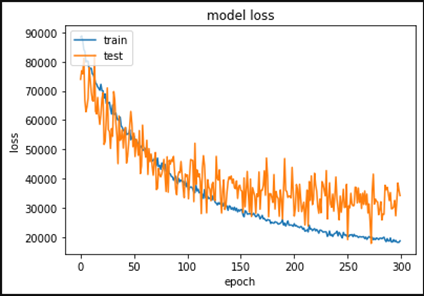 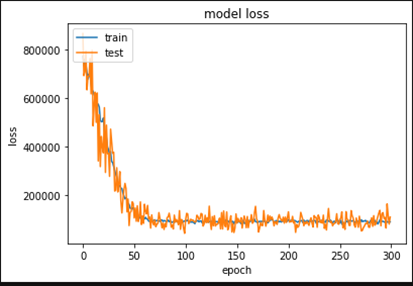



## Evaluation <a class="anchor" id="eval"></a>

We will now compare the results of the different models on a clean evaluation set `eval_df`. 

Note: in oder to use the `test_on_image` function to visualize the heatmaps of network layers in the model, you will need to use version 0.23.2 of sklearn. If you don't plan on visualizing heatmaps, no need to install this old version. You can still use the `test_on_image` function. Just ensure that the `display_activations` flag is set to False (default).

The `test_on_image` function can take any size of the dataframe and evaluate the performance of a given model. The function will output the average error and accuracy of the given set of inputs. 

Accuracy is calculated using the following formula: $$ a = (1 -  \frac{ε} {N}) * 100 \% $$
The average error is calculated by: $$ Error_{avg} = \frac{ε} {N} * 100\% $$
Where $ ε $ is the residuals of the predictions made: $$ \epsilon =  \sum \limits _{i=0} ^{N} \frac {|y - \hat{y}|} {y} $$ 
The function also has options to view the images as well as the activations within the network model.  

In [ ]:
!pip install scikit-learn==0.23.2

In [25]:
from matplotlib.patches import Patch

def display_activation(model, image_frame):
    
    """
    Displays heatmaps of each layer overlaid onto the original image.
    :param model: Keras compiled model
    :param image_frame: The pandas frame from which to get the X and y data to feed the model.
    """
    
    img_path = image_frame.path
    if os.path.exists(img_path):
        img = image.load_img(img_path, target_size=(224, 224), color_mode=color)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x/255.

        activations = keract.get_activations(model, x, layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
        #keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)
        keract.display_heatmaps(activations, x, save=False)
        #return heatmap, output

        
def test_on_image(models, image_frame, model_labels = [], display_each=True, display_width = 3):
    
    """
    Run model on set of images in the given pandas frame. The image frame must include a ['path'] column to the image as well as a 
    ['weight'] column with the true values for the image. 
    
    :param model: Keras compiled model
    :param image_frame: The pandas frame from which to get the X and y data to feed through the model.
    :param display_each: (optional) If this is True, each image in the frame will be displayed inline along with its given truth
    and prediction.
    :param display_activation: (optional) If this is True, an activation map will be overlayed onto the image to show 
    "where the network is looking" for the given image. In this case, 'display_each' should also be set to True.
    :return: Prints the average error and accuracy of the given test set. Returns the accuracy score. 
    """
        
    # handle model_labels length mismatch
    if len(model_labels) == 0:
        for i in range(len(models)):
            model_labels.append('Model '+str(i))
            
    elif len(model_labels) != len(models):
        raise ValueError("Number of model labels does not match number of models")
    
    # display a loading bar
    if not display_each:
        pbar = tqdm(total=len(image_frame))
    
    else:
        display_width = min(display_width, len(image_frame))
        fig, ax = plt.subplots(max(len(image_frame)//display_width, 1), min(display_width, len(image_frame)), figsize=(4.5*display_width, 4*len(image_frame)//display_width))
        fig.tight_layout()
        #plt.rcParams["figure.figsize"] = [12.2, 5.5]
        plt.rcParams["figure.autolayout"] = True
    
    error = np.zeros(len(models))
    pred = np.zeros(len(models))
    non_existent = 0
    
    # test on all the models and all the images
    for i in range(len(image_frame)):
        
        img_path = image_frame.iloc[i].path
            
        if os.path.exists(img_path):
            img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x/255.
                
            # get predictions from each model to be tested
            for j, model in enumerate(models):

                # set the color mode based on the number of color channels in the model
                if model.input_shape[3] == 1:
                    x_ = x[:, :, :, 1]
                else:
                    x_ = x

                pred[j] = model.predict(x_)[0][0]

            # display the results 
            if display_each:
                barwidth = 16
                font_size = 12

                if type(ax) == np.ndarray:
                    if len(ax.shape) == 1:
                        a = ax[i]
                    else:
                        a = ax[i//3][i%3]
                else:
                    a = ax

                ax_ = a.twinx()
                ax_1 = ax_.twinx()
                im = a.imshow(img, extent=[0, 224, 0, 224])
                horiz = np.array(range(barwidth, len(pred)*barwidth+barwidth, barwidth))
                acc = (1 - np.abs(np.full(len(pred), image_frame.iloc[i].weight) - np.array(pred))/np.full(len(pred), image_frame.iloc[i].weight))*100

                ax_.bar(x = horiz, tick_label = model_labels, width=barwidth, linewidth=2, edgecolor='black', height = acc, alpha=0.5)
                ax_1.bar(x = 224 - np.flip(horiz, axis=0), tick_label = [label+'_' for label in np.flip(model_labels, axis=0)], width=barwidth, linewidth=2, color='orange', edgecolor='black', height = pred, alpha = 0.5)
                ax_1.bar(x = 224 - barwidth*(len(pred)+1), width=barwidth*(len(pred)+1), linewidth=2, align='edge', color='red', edgecolor='white', height=image_frame.iloc[i].weight, alpha=0.2)
                
                # print accuracy values
                for k, val in enumerate(acc):
                    ax_.text(horiz[k] - 4, val/2 - 10, '{:.1f}%'.format(val), color = 'white', fontweight = 'bold', rotation = 'vertical', size=font_size)
                    
                # print weight values
                for k, val in enumerate(acc):
                    ax_.text(224 - horiz[k] - 4, val/2 - 10, '{:.1f}%'.format(val), color = 'white', fontweight = 'bold', rotation = 'vertical', size=font_size)
                    
                #ax_.set_aspect('equal', adjustable=None, anchor=None, share=False)
                legend_elements = [Patch(facecolor='red', edgecolor='black',
                             label='True Weight'),
                       Patch(facecolor='orange', edgecolor='black',
                             label='Predicted Weight'),
                       Patch(facecolor='C0', edgecolor='black',
                             label='Accuracy')]

                #ax_.set_ylabel('Accuracy')
                ax_.set_xticks(np.concatenate([horiz, 224-np.flip(horiz, axis=0)], axis=0), labels=np.concatenate([model_labels, model_labels], axis=0))
                ax_1.set_ylabel('lbs')
                ax_1.set_ylim(0, 1500)
                ax_.set_ylim(0, 120)
                ax_.set_yticks(range(0, 125, 25))
                a.set_yticks([])
                a.tick_params(axis='x', labelrotation= 70)
                a.set_title('Actual Weight: {} lbs'.format(image_frame.iloc[i].weight))
                #print('Predicted: {} lbs, Actual: {} lbs'.format(pred, image_frame.iloc[i].weight))

            # accumulate the error over the set of inputs
            error += abs(image_frame.iloc[i].weight - pred) / image_frame.iloc[i].weight 
        else:
            non_existent += 1
        
        if not display_each:
            pbar.update(1)
    
    if display_each:
        fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0., 0.92, 0.02, 0.102),
                          ncol=1, borderaxespad=0.)
        fig.suptitle('Model Comparison', fontsize=30, verticalalignment='top')
        #plt.xticks(rotation='vertical')
        plt.show()

    # calculate the error and accuracy as an average for the set
    #print('{} average Error Rate: {:.2f}%'.format(model_labels[j], error[j]*100 / (len(image_frame) - non_existent)))
    acc = (1-error / (len(image_frame) - non_existent))*100
    
    for i, label in enumerate(model_labels):
        print('{} average accuracy: {:.2f}%'.format(label, acc[i]))    
        
    return acc


We will use the previous function to compare the results of the CNN and ViT models. Since the cct model had poor results, we will use the only the generic ViT model for comparison with the CNNs. 

In [22]:
model = keras.models.load_model(DATABASE_LOCATION+"/models/custom_best_model")
model_vit = keras.models.load_model(DATABASE_LOCATION+"/models/vit_best_model")

In [27]:
model_xcept = keras.models.load_model(DATABASE_LOCATION+"/models/exceptionet_best_model")

We can visualize a sampled image and compare the results from all three networks on that image. 

Below are some visual examples of data run on the three models:

In [411]:
# get a random sample from the evaluaiton set
sample = ev_df.sample(n=24)

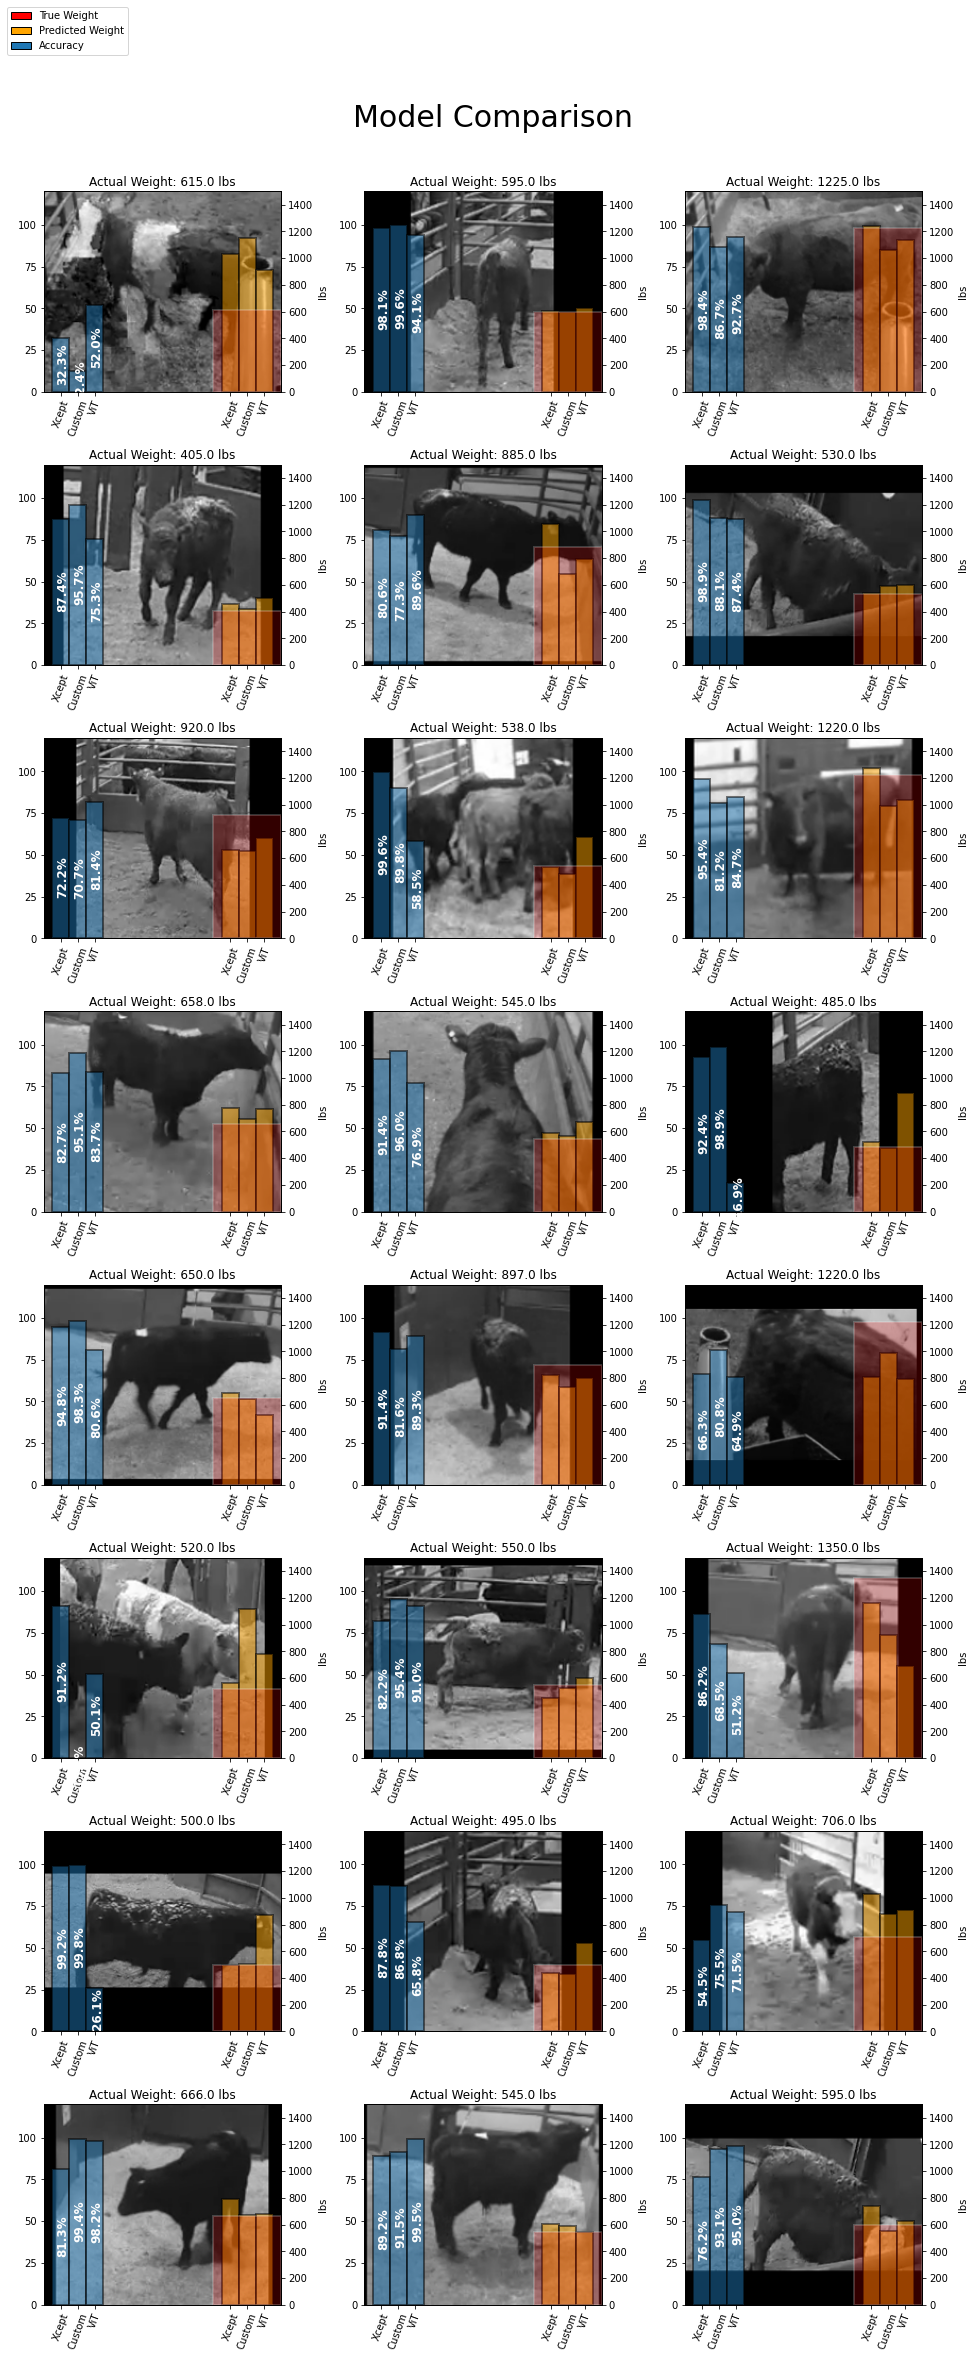

Xcept average accuracy: 84.57%
Custom average accuracy: 81.11%
ViT average accuracy: 74.02%


In [415]:
test_on_image([model_ex_orig, model, model_vit], sample, model_labels = ['Xcept', 'Custom', 'ViT']);

We will also evaluate the overall performance of all three networks on the entire evaluation set. 

In [33]:
acc = test_on_image([model_xcept, model, model_vit], ev_df, model_labels = ['Xcept', 'Custom', 'ViT'], display_each=False)

  0%|          | 0/4589 [00:00<?, ?it/s]

Xcept average accuracy: 85.47%
Custom average accuracy: 82.08%
ViT average accuracy: 73.68%


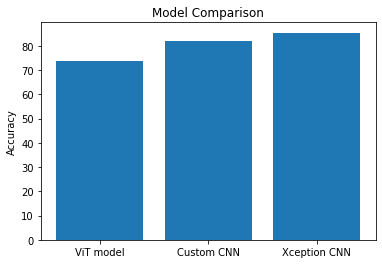

In [261]:
plt.bar(x = ['ViT model', 'Custom CNN', 'Xception CNN'], height = [vit_acc, custom_acc, ex_acc], edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

Notice that our evaluatoin accuracy is much lower than our validation accuracy from training. This is not only an entirely separate set of images, but it is an entirely separate set of cows. 

## Future Work 
1. Data Cleaning

It is imparitive that clean data is fed into the network at the time of training. There are still some images that are poor quality for training. These include images with occlusion, images with multiple cows, and images with blurred body parts. 

2. Data Amount

As more data is collected, the models will continue to be trained on more data. This will hopfully increase the overall accuracy of the models. The ViT architecture especially has been shown to train better with larger amounts of data.

3. Multi-Angle Model

For a professional human estimating the weight of an animal by sight, it is important to look at multiple angles of the cow. This accounts for cows having hidden areas of weight such as extra width. 
Future models will allow images from multiple angles of the cow for a more accurate estimation. 